In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

# Polynomial distortion described by Mallon and Whelan

In [2]:
def polynomial_distortion(image, k1, k2, scale=1): 
    # Create a meshgrid of pixel coordinates
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

    # Normalize the coordinates to the range [-1, 1]
    x_u = 2 * x / x.max() - 1
    y_u = 2 * y / y.max() - 1

    # Calculate the polar coordinates
    ru = np.sqrt(x_u**2 + y_u**2)

    # Apply the distortion
    x_d = x_u + ( k1 * x_u * ru**2 + k2 * x_u * ru**4 )
    y_d = y_u + ( k1 * y_u * ru**2 + k2 * y_u * ru**4 )

    # Scale the image after transformation
    x_d = x_d / scale
    y_d = y_d / scale
    
    # Convert back to pixel coordinates
    x_d = (x_d * (image.shape[1] / 2) + image.shape[1] / 2).astype(np.float32)
    y_d = (y_d * (image.shape[0] / 2) + image.shape[0] / 2).astype(np.float32)


    # Remap the image using the distorted coordinates
    distorted_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            x_new = int(x_d[i, j])
            y_new = int(y_d[i, j])
            if 0 <= x_new < image.shape[1] and 0 <= y_new < image.shape[0]:
                distorted_image[i, j] = image[y_new, x_new]

    # Scale the image after transformation
    if scale != 1:
        distorted_image = cv2.resize(distorted_image, (0, 0), fx=scale, fy=scale)

    return distorted_image

def polynomial_correction(image, k1, k2, scale=1): 
    # Create a meshgrid of pixel coordinates
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

    # Normalize the coordinates to the range [-1, 1]
    x_d = 2 * x / x.max() - 1
    y_d = 2 * y / y.max() - 1

    # Calculate the polar coordinates
    rd = np.sqrt(x_d**2 + y_d**2)

    # Apply the distortion
    x_u = x_d - x_d * ((k1 * rd**2 + k2 * rd**4 + k1**2 * rd**4 + k2**2 * rd**8 + 2 * k1 * k2 * rd**6 ) / (1 + 4 * k1 * rd**2 + 6 * k2 * rd**4))
    y_u = y_d - y_d * ((k1 * rd**2 + k2 * rd**4 + k1**2 * rd**4 + k2**2 * rd**8 + 2 * k1 * k2 * rd**6 ) / (1 + 4 * k1 * rd**2 + 6 * k2 * rd**4))
    
    # Scale the image after transformation
    x_u = x_u / scale
    y_u = y_u / scale

    # Convert back to pixel coordinates
    x_u = (x_u * (image.shape[1] / 2) + image.shape[1] / 2).astype(np.float32)
    y_u = (y_u * (image.shape[0] / 2) + image.shape[0] / 2).astype(np.float32)


    # Remap the image using the distorted coordinates
    corrected_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            x_new = int(x_u[i, j])
            y_new = int(y_u[i, j])
            if 0 <= x_new < image.shape[1] and 0 <= y_new < image.shape[0]:
                corrected_image[i, j] = image[y_new, x_new]

    return corrected_image

# Non Polynomial models.

In [3]:
def apply_or_correct_distortion(img, t=lambda x: x, scale=1):
    # Create a meshgrid of pixel coordinates
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))

    # Normalize the coordinates to the range [-1, 1]
    x_n = 2 * x / x.max() - 1
    y_n = 2 * y / y.max() - 1

    # Calculate the polar coordinates
    phi = np.arctan2(y_n, x_n)
    r = np.sqrt(x_n**2 + y_n**2)

    # Apply the transformation
    r_t = t(r)

    # Convert back to Cartesian coordinates
    x_t = r_t * np.cos(phi)
    y_t = r_t * np.sin(phi)

    # Scale the image after transformation
    x_t = x_t / scale
    y_t = y_t / scale
    
    # Convert back to pixel coordinates
    x_t = (x_t * (img.shape[1] / 2) + img.shape[1] / 2).astype(np.float32)
    y_t = (y_t * (img.shape[0] / 2) + img.shape[0] / 2).astype(np.float32)


    # Remap the image using the transformed coordinates
    t_img = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x_new = int(x_t[i, j])
            y_new = int(y_t[i, j])
            if 0 <= x_new < img.shape[1] and 0 <= y_new < img.shape[0]:
                t_img[i, j] = img[y_new, x_new]

    return t_img


# Loading an image

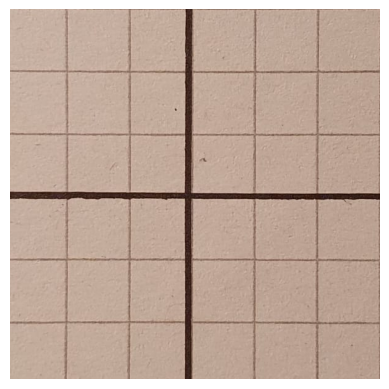

In [4]:
# Load a new image using OpenCV
image = cv2.imread('./img/grid2.jpg')
# Convert the image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get the dimensions of the image
height, width, _ = image.shape

# Calculate the central coordinates
start_x = width // 2 - 300
start_y = height // 2 - 300
end_x = start_x + 600
end_y = start_y + 600

# Crop the central pixels
image = image[start_y:end_y, start_x:end_x]

# Display the cropped image
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
# figure save resulution
res = 400

# Printing the models

In [6]:
def plot_distortion(image, distorted_image, corrected_image, filename):
    plt.figure(figsize=(15, 5))  # Increase the plot size

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')

    # Plot the distorted image
    plt.subplot(1, 3, 2)
    plt.title('Distorted Image')
    plt.imshow(distorted_image)
    plt.axis('off')

    # Plot the corrected image
    plt.subplot(1, 3, 3)
    plt.title('Corrected Image')
    plt.imshow(corrected_image)
    plt.axis('off')

    # Save the corrected image with reduced whitespace
    plt.savefig(f'output_folder/{filename}', dpi=res, bbox_inches='tight')
    plt.show()

# Odd Polynomial Model described by Mallon and Whelan

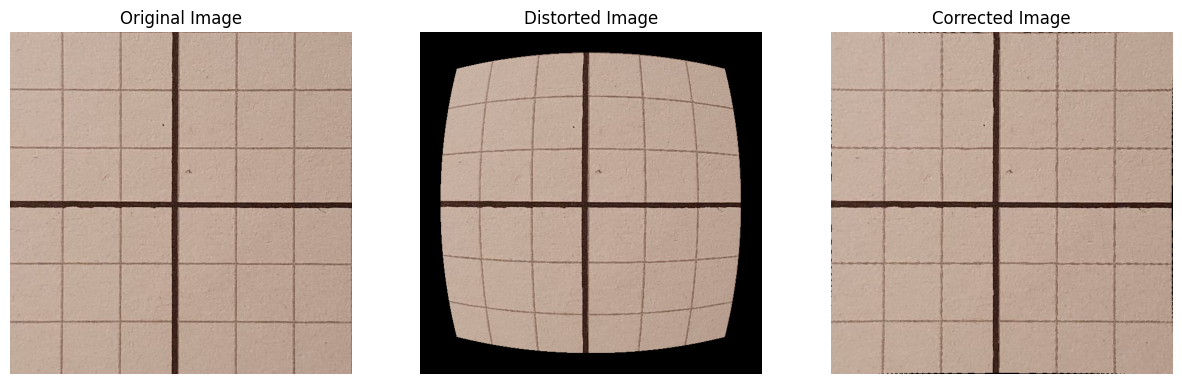

In [7]:
# Parameter
k1 = 0.1
k2 = 0.1

# Apply the distortion to the image
distorted_image = polynomial_distortion(image, k1, k2)

# Correct the distortion
corrected_image = polynomial_correction(distorted_image, k1, k2)

# Plot the distortion
plot_distortion(image, distorted_image, corrected_image, "1_odd_polynomial_model.jpg")

# Fisheye transformation described by Basu and Licardie

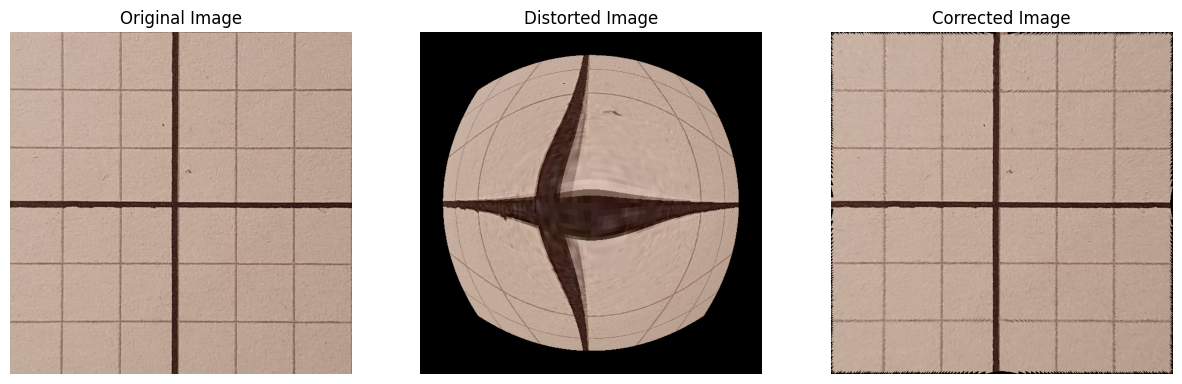

In [8]:
# Parameter
l = 75
s = 0.2

# Define the distortion and correction functions
distortion_basu_and_licardie = lambda r : (np.exp(r / s) - 1) / l
correction_basu_and_licardie = lambda r : s * np.log(1 + l * r)

# Apply the distortion to the image
distorted_image = apply_or_correct_distortion(image, distortion_basu_and_licardie)

# Correct the distortion
corrected_image = apply_or_correct_distortion(distorted_image, correction_basu_and_licardie)

# Plot the distortion
plot_distortion(image, distorted_image, corrected_image, "2_fisheye_model_basu_and_licardie.jpg")

# Fisheye transform described by Devernay and Faugeras

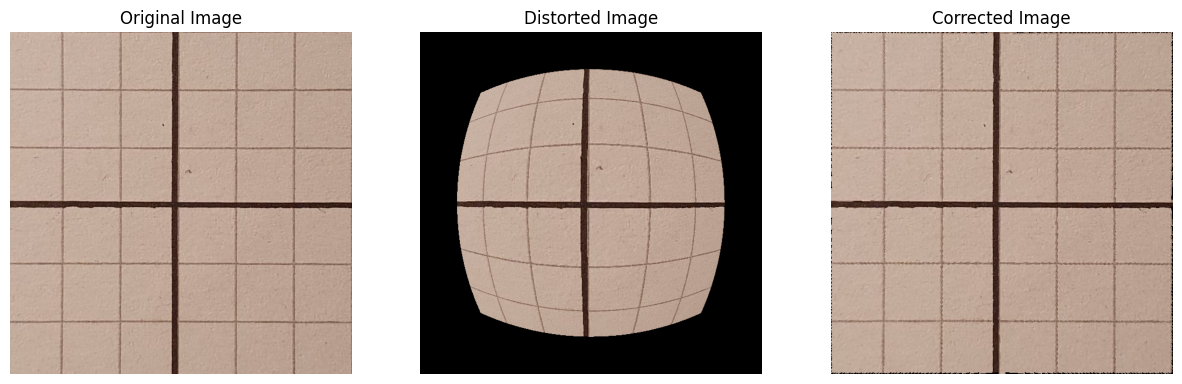

In [9]:
# Parameter
omega = 1.2

# Define the distortion and correction functions
distortion_devernay_and_faugeras = lambda r : (np.tan(r * omega) ) / (2 * np.tan(omega / 2))
correction_devernay_and_faugeras = lambda r : (1/omega) * np.arctan(2 * r * np.tan(omega / 2))

# Apply the distortion to the image
distorted_image = apply_or_correct_distortion(image, distortion_devernay_and_faugeras)

# Correct the distortion
corrected_image = apply_or_correct_distortion(distorted_image, correction_devernay_and_faugeras)

# Plot the distortion
plot_distortion(image, distorted_image, corrected_image, "3_fisheye_model_devernay_and_faugeras.jpg")

# Fisheye transformation as perspective model described by Ishii, Sudo, and Hashimoto

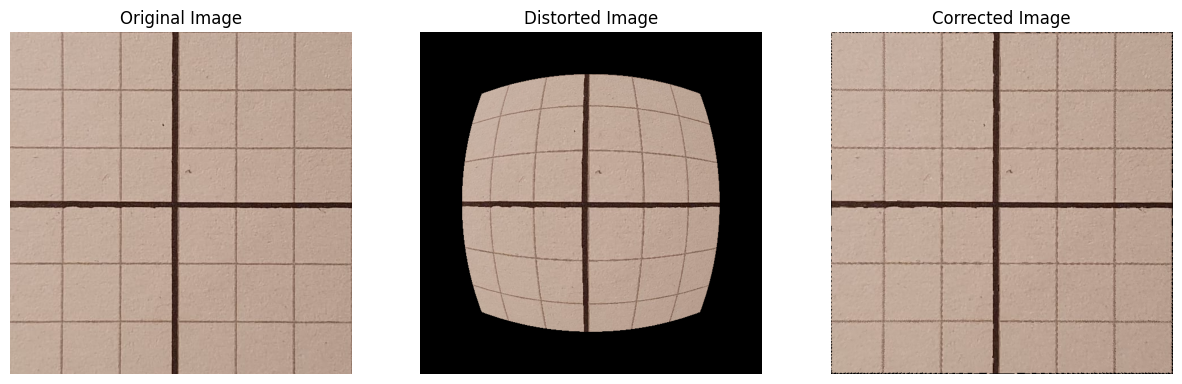

In [10]:
# Parameter
f = 0.9
distortion_perspective = lambda r : f * np.tan(r / f)
correction_perspective = lambda r :  f * np.arctan(r / f) 

# Apply the distortion to the image
distorted_image = apply_or_correct_distortion(image, distortion_perspective)

# Correct the distortion
corrected_image = apply_or_correct_distortion(distorted_image, correction_perspective)

# Plot the distortion
plot_distortion(image, distorted_image, corrected_image, "4_perspective_fisheye_model.jpg")

# Correction of the distorted image given by the lecture

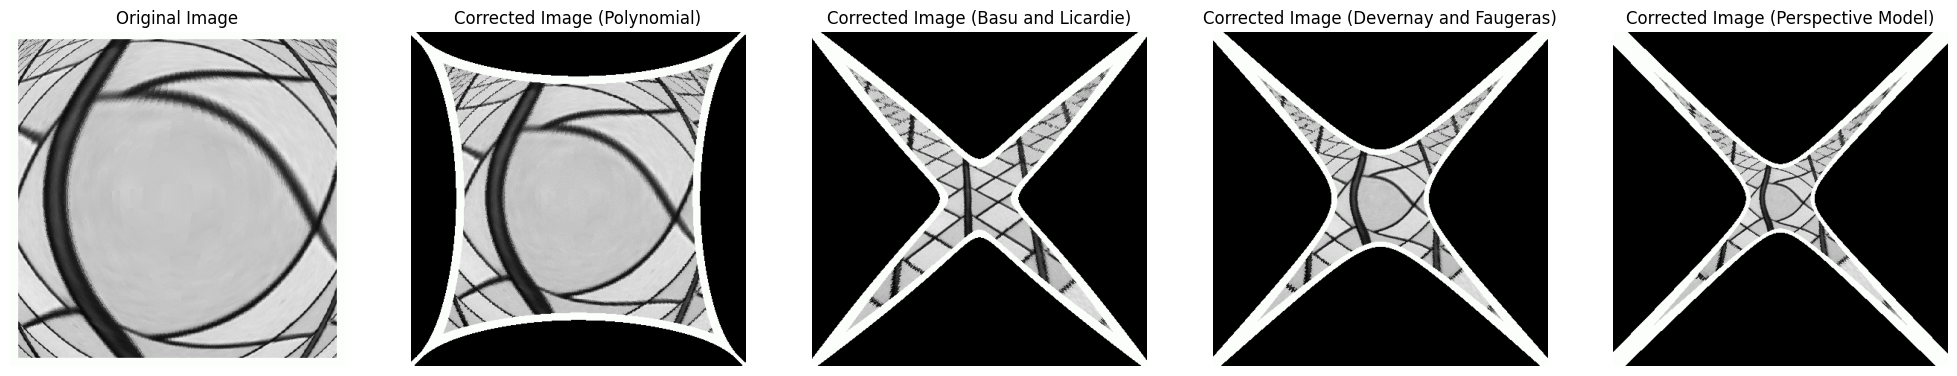

In [11]:
distorted_image = cv2.VideoCapture('./img/TileNonlinear.gif')
ret, distorted_image = distorted_image.read()
distorted_image = cv2.cvtColor(distorted_image, cv2.COLOR_BGR2RGB)

# Correct the distortion using polynomial model described by Mallon and Whelan
k1 = 0.2
k2 = 0.2
corrected_image_polynomial = polynomial_correction(distorted_image, k1, k2, scale=0.65)


# Correction parameters for Basu and Licardie model
l =  400
s = 0.22
# correction = lambda r : (np.exp(r / s) - 1) / l
correction = lambda r : s * np.log(1 + l * r)
corrected_image_basu = apply_or_correct_distortion(distorted_image, correction)

# Correction parameters for Devernay and Faugeras model
omega = 2.5
correction = lambda r : ((1/omega) * np.arctan(2 * r * np.tan(omega / 2))/2)
# correction = lambda r : r
corrected_image_devernay = apply_or_correct_distortion(distorted_image, correction, scale=0.21)


# Correction parameters for perspective model
f = 0.105
correction = lambda r : f * np.arctan(r / f)
corrected_image_perspective = apply_or_correct_distortion(distorted_image, correction, scale=0.115)

# Plot the original image
plt.figure(figsize=(25, 5))
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(distorted_image)
plt.axis('off')

# Plot the corrected image using polynomial model
plt.subplot(1, 5, 2)
plt.title('Corrected Image (Polynomial)')
plt.imshow(corrected_image_polynomial)
plt.axis('off')

# Plot the corrected image using Basu and Licardie model
plt.subplot(1, 5, 3)
plt.title('Corrected Image (Basu and Licardie)')
plt.imshow(corrected_image_basu)
plt.axis('off')

# Plot the corrected image using Devernay and Faugeras model
plt.subplot(1, 5, 4)
plt.title('Corrected Image (Devernay and Faugeras)')
plt.imshow(corrected_image_devernay)
plt.axis('off')

# Plot the corrected image using perspective model
plt.subplot(1, 5, 5)
plt.title('Corrected Image (Perspective Model)')
plt.imshow(corrected_image_perspective)
plt.axis('off')

# Save the corrected images with 1200 dpi
plt.savefig('output_folder/5_corrected_images_comparison.jpg', dpi=res, bbox_inches='tight')

plt.show()